# [ EXPLORATION ] 5. 인공지능과 가위바위보하기

✅손글씨 이미지(MNIST)를 분류하는 간단한 이미지 분류기를 keras를 활용하여 제작해 보고, 이를 응용하여 가위바위보 이미지를 분류해 보는 프로젝트를 진행한다.

---
### - 📖목차
* ✔️5-7. 미니 프로젝트: 가위바위보 분류기를 만들자
* ✔️더 좋은 네트워크 만들어보기
    <br>1. 모델 제작시 데이터 수 3:1로 변경(900:300)
    <br>2. 데이터 수 10:1 로 변경(6000:600) + 모델 하이퍼 파라미터 변경
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️5-7. 미니 프로젝트: 가위바위보 분류기를 만들자
---
### 1. 데이터를 준비하자

* 데이터는 아지트에서 지난 기수에서 모아주신 가위바위보 데이터 + 아이펠 LMS 내 드라이브에 있는 데이터를 취합했습니다.

In [ ]:
# 데이터가 많이 드는 작업이라 GPU 환경인지 먼저 확인
import tensorflow as tf
print("- 현재 연결된 [ GPU ]개수 : ", len(tf.config.experimental.list_physical_devices('GPU')))

- 현재 연결된 [ GPU ]개수 :  1


In [ ]:
# 모듈 로드
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# 이미지 관련 모듈 로드
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image 

import os
import glob #파일 경로 라이브러리

In [ ]:
# 데이터 불러오기(코랩 환경이라 google 마운트를 씁니다)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 파일 경로 확인(전체)
!ls '/content/gdrive/MyDrive/aiffel/ex_05/' #ver_04까지 있었는데... 마지막껀 업로드 시간상 못썼습니다()

ex05_ver_01  ex05_ver_02  ex05_ver_03  ex05_ver_04


* 파일 체크

1. ex05_ver_01: train(300), test(300)
2. ex05_ver_02: train(900), test(300)
3. ex05_ver_03: train(6000), test(600) >> 최종 데이터

= 파일 출처는 Aiffel 아지트에서 전 기수분들이 취합해 올려주신 걸 썼습니다.(감사합니다!)

In [ ]:
# 파일 경로 확인(train 데이터에 가위 100개 파일이 있는 걸 확인) = 이걸 경로 위치로 씁니다.
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train/scissor'

0.jpg	19.jpg	28.jpg	37.jpg	46.jpg	55.jpg	64.jpg	73.jpg	82.jpg	91.jpg
10.jpg	1.jpg	29.jpg	38.jpg	47.jpg	56.jpg	65.jpg	74.jpg	83.jpg	92.jpg
11.jpg	20.jpg	2.jpg	39.jpg	48.jpg	57.jpg	66.jpg	75.jpg	84.jpg	93.jpg
12.jpg	21.jpg	30.jpg	3.jpg	49.jpg	58.jpg	67.jpg	76.jpg	85.jpg	94.jpg
13.jpg	22.jpg	31.jpg	40.jpg	4.jpg	59.jpg	68.jpg	77.jpg	86.jpg	95.jpg
14.jpg	23.jpg	32.jpg	41.jpg	50.jpg	5.jpg	69.jpg	78.jpg	87.jpg	96.jpg
15.jpg	24.jpg	33.jpg	42.jpg	51.jpg	60.jpg	6.jpg	79.jpg	88.jpg	97.jpg
16.jpg	25.jpg	34.jpg	43.jpg	52.jpg	61.jpg	70.jpg	7.jpg	89.jpg	98.jpg
17.jpg	26.jpg	35.jpg	44.jpg	53.jpg	62.jpg	71.jpg	80.jpg	8.jpg	99.jpg
18.jpg	27.jpg	36.jpg	45.jpg	54.jpg	63.jpg	72.jpg	81.jpg	90.jpg	9.jpg


In [ ]:
img_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train/scissor'

In [ ]:
# Resize함수
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [ ]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들인다
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train/scissor'
resize_images(image_dir_path)

print("- 가위 이미지 resize 완료")

100  images to be resized.
100  images resized.
- 가위 이미지 resize 완료


In [ ]:
# 바위 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train/rock'
resize_images(image_dir_path)

print("- 바위 이미지 resize 완료")

100  images to be resized.
100  images resized.
- 바위 이미지 resize 완료


In [ ]:
# 보 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train/paper'
resize_images(image_dir_path)

print("- 보 이미지 resize 완료")

100  images to be resized.
100  images resized.
- 보 이미지 resize 완료


In [ ]:
# 가위바위보 라벨링

img_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train'

def load_data(img_path, number_of_data=300):  # 1차 가위바위보 이미지 개수 총합 300
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'): # 가위는 0으로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'): # 바위는 1로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'): # 보는 2로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   
        idx=idx+1
        
    print("- 데이터의 이미지 개수는[", idx,"]개 입니다.")
    return imgs, labels

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/train/'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("- x_train shape : {}".format(x_train.shape))
print("- y_train shape : {}".format(y_train.shape))

- 데이터의 이미지 개수는[ 300 ]개 입니다.
- x_train shape : (300, 28, 28, 3)
- y_train shape : (300,)


라벨:  0


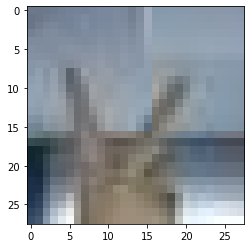

In [ ]:
# 라벨링이 제대로 됐는지 확인하기
plt.imshow(x_train[2])
print('라벨: ', y_train[0])

* 라벨이 0 > 가위가 나와야 정상이므로 데이터가 정상적으로 라벨링 된 것을 확인했다.

### 2. 딥러닝 네트워크 설계하기

In [ ]:
# Sequential Model을 사용해보자

# 처음에는 mnist의 값을 참고한 기본값으로 만들기
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu')) # 중간의 Dense만 50으로 변경
model.add(keras.layers.Dense(3, activation='softmax'))

print('- Model에 추가된 Layer 개수: ', len(model.layers))

- Model에 추가된 Layer 개수:  7


In [ ]:
# 모델 정보 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 50)                4

### 3. 답러닝 네트워크 학습시키기

In [ ]:
# epoch 10, 옵티마이저 adam, 손실함수는 cross entropy로 학습하기
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train_norm, y_train , epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 1.1009 - accuracy: 0.3333
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0974 - accuracy: 0.3467
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0908 - accuracy: 0.3500
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0789 - accuracy: 0.3767
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0590 - accuracy: 0.5633
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0390 - accuracy: 0.6900
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9971 - accuracy: 0.7800
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9556 - accuracy: 0.6933
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.9103 - accuracy: 0.6500
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8351 - accuracy: 0.7767


* 이렇게만 보면 훈련이 잘 됬다고 생각했는데, 후반부에 loss값이 확 떨어지고 accuracy가 99에 가까운 모델을 보고 나니 아무래도 Epoch를 더 주면 좀 더 정확한 모델이 되지 않았을까 추측해본다.

### 4. 얼마나 잘 만들었는지 확인하기(테스트)

In [ ]:
# 파일 내의 test에 폴더들이 제대로 있는지 확인
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test/'

paper  rock  scissor


In [ ]:
# 테스트 사이즈 내의 이미지들이 제대로 들어있는지 체크(총 100개의 이미지)
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test/scissor'

0.jpg	19.jpg	28.jpg	37.jpg	46.jpg	55.jpg	64.jpg	73.jpg	82.jpg	91.jpg
10.jpg	1.jpg	29.jpg	38.jpg	47.jpg	56.jpg	65.jpg	74.jpg	83.jpg	92.jpg
11.jpg	20.jpg	2.jpg	39.jpg	48.jpg	57.jpg	66.jpg	75.jpg	84.jpg	93.jpg
12.jpg	21.jpg	30.jpg	3.jpg	49.jpg	58.jpg	67.jpg	76.jpg	85.jpg	94.jpg
13.jpg	22.jpg	31.jpg	40.jpg	4.jpg	59.jpg	68.jpg	77.jpg	86.jpg	95.jpg
14.jpg	23.jpg	32.jpg	41.jpg	50.jpg	5.jpg	69.jpg	78.jpg	87.jpg	96.jpg
15.jpg	24.jpg	33.jpg	42.jpg	51.jpg	60.jpg	6.jpg	79.jpg	88.jpg	97.jpg
16.jpg	25.jpg	34.jpg	43.jpg	52.jpg	61.jpg	70.jpg	7.jpg	89.jpg	98.jpg
17.jpg	26.jpg	35.jpg	44.jpg	53.jpg	62.jpg	71.jpg	80.jpg	8.jpg	99.jpg
18.jpg	27.jpg	36.jpg	45.jpg	54.jpg	63.jpg	72.jpg	81.jpg	90.jpg	9.jpg


In [ ]:
# 기본 테스트 이미지 경로
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test/'

In [ ]:
# 테스트 데이터 로드 + 테스트 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test/rock'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test/scissor'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test/paper'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_01/test'
(x_test, y_test)=load_data(image_dir_path)

# 입력은 0~1 사이의 값으로 정규화
x_test_norm = x_test/255.0   

print("- x_test shape: {}".format(x_test_norm.shape))
print("- y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
- 데이터의 이미지 개수는[ 300 ]개 입니다.
- x_test shape: (300, 28, 28, 3)
- y_test shape: (300,)


In [ ]:
# 테스트 데이터로 성능을 확인
loss_1, accu_1  = model.evaluate(x_test_norm, y_test, verbose=2)

print("- test_loss: {} ".format(loss_1))
print("- test_accuracy: {}".format(accu_1))

10/10 - 0s - loss: 1.2565 - accuracy: 0.2833 - 123ms/epoch - 12ms/step
- test_loss: 1.2564911842346191 
- test_accuracy: 0.28333333134651184


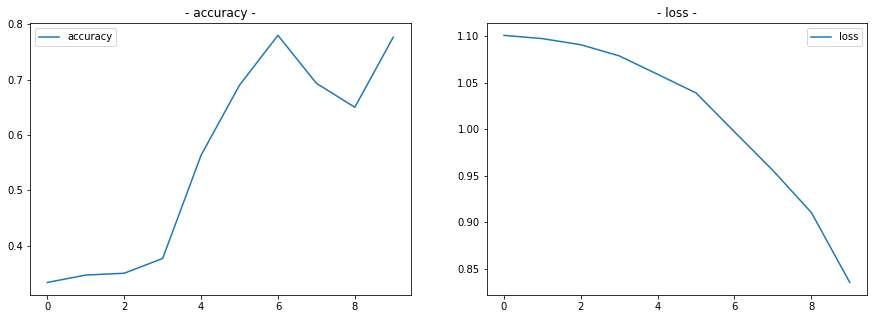

In [ ]:
plt.figure(figsize=(15, 5))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.title("- accuracy -")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="loss")
plt.title("- loss -")
plt.legend()

plt.show()

* 최초로 만든 모델의 경우, 

1. loss값은 1.25 
2. 정확도는 0.28

로 매우 저조한 효율을 자랑했다. 여기서 쓰인 train과 test 데이터의 비율은 [ 300 : 300 ]장을 기본으로 [ 1:1 ]을 자랑했고, Dense를 50을 준 거 빼고는 현재 아무런 하이퍼 파라미터를 건드리지 않은 상태다. 중간에 그래프를 보면 정확도가 급격하게 올라갔다가 팍 떨어졌다가 다시 올라가는 지점이 있는데, 아무래도 저기가 오버피팅이 아닌가 짐작해본다. Loss 값은 꾸준히 떨어지고 있긴 한데 다른 Loss값의 일반적인 그래프를 보면 오히려 반대방향이 불룩 튀어나와서 정상범주는 아닌 것 같다.

이제 이걸 기본으로 해서 다른 모델을 제작한다.

<br>

## ✔️더 좋은 네트워크 만들어보기
---
* 시험용 데이터가 들어갔을 때 test accuracy가 train accuracy보다 많이 낮게 나왔다면, test accuracy가 train accuracy에 근접하도록 개선 방법을 찾아본다. 여기서는 하이퍼 파라미터와 모델 셋에 따른 모델의 성능 차를 간단하게 다룬다.

### 1. 모델 제작시 데이터 수 3:1로 변경(900:300)

#### 1-1. 새로운 데이터로 모델 재생성

In [ ]:
# 2번째 데이터 경로 체크
img_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train/scissor'

In [ ]:
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train/scissor' #이번에는 300개의 이미지

s0.jpg	  s134.jpg  s169.jpg  s202.jpg	s237.jpg  s271.jpg  s35.jpg  s6.jpg
s100.jpg  s135.jpg  s16.jpg   s203.jpg	s238.jpg  s272.jpg  s36.jpg  s70.jpg
s101.jpg  s136.jpg  s170.jpg  s204.jpg	s239.jpg  s273.jpg  s37.jpg  s71.jpg
s102.jpg  s137.jpg  s171.jpg  s205.jpg	s23.jpg   s274.jpg  s38.jpg  s72.jpg
s103.jpg  s138.jpg  s172.jpg  s206.jpg	s240.jpg  s275.jpg  s39.jpg  s73.jpg
s104.jpg  s139.jpg  s173.jpg  s207.jpg	s241.jpg  s276.jpg  s3.jpg   s74.jpg
s105.jpg  s13.jpg   s174.jpg  s208.jpg	s242.jpg  s277.jpg  s40.jpg  s75.jpg
s106.jpg  s140.jpg  s175.jpg  s209.jpg	s243.jpg  s278.jpg  s41.jpg  s76.jpg
s107.jpg  s141.jpg  s176.jpg  s20.jpg	s244.jpg  s279.jpg  s42.jpg  s77.jpg
s108.jpg  s142.jpg  s177.jpg  s210.jpg	s245.jpg  s27.jpg   s43.jpg  s78.jpg
s109.jpg  s143.jpg  s178.jpg  s211.jpg	s246.jpg  s280.jpg  s44.jpg  s79.jpg
s10.jpg   s144.jpg  s179.jpg  s212.jpg	s247.jpg  s281.jpg  s45.jpg  s7.jpg
s110.jpg  s145.jpg  s17.jpg   s213.jpg	s248.jpg  s282.jpg  s46.jpg  s80.jpg
s111.jpg  s146.j

In [ ]:
# 가위 이미지가 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train/scissor'
resize_images(image_dir_path)

print("- 가위 이미지 resize 완료")

# 바위 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train/rock'
resize_images(image_dir_path)

print("- 바위 이미지 resize 완료")

# 보 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train/paper'
resize_images(image_dir_path)

print("- 보 이미지 resize 완료")

300  images to be resized.
300  images resized.
- 가위 이미지 resize 완료
300  images to be resized.
300  images resized.
- 바위 이미지 resize 완료
300  images to be resized.
300  images resized.
- 보 이미지 resize 완료


In [ ]:
# 가위바위보 라벨링

img_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train'

def load_data(img_path, number_of_data=900):  # 1차 가위바위보 이미지 개수 총합 900장으로 증가
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'): # 가위는 0으로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'): # 바위는 1로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'): # 보는 2로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   
        idx=idx+1
        
    print("- 데이터의 이미지 개수는[", idx,"]개 입니다.")
    return imgs, labels

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/train/'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("- x_train shape : {}".format(x_train.shape))
print("- y_train shape : {}".format(y_train.shape))

- 데이터의 이미지 개수는[ 900 ]개 입니다.
- x_train shape : (900, 28, 28, 3)
- y_train shape : (900,)


* 가위(300), 바위(300), 보(300) 총 900개의 이미지가 train용으로 준비되어 리사이즈 되었다.

라벨:  0


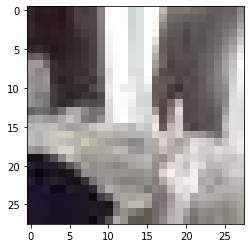

In [ ]:
# 라벨링이 제대로 됐는지 확인하기
plt.imshow(x_train[1])
print('라벨: ', y_train[0])

* 여기서의 라벨 0은 가위를 뜻하므로, 가위 사진이 나온 것을 체크하고서 데이터가 제대로 올겨와 라벨링된 것을 확인했다.

In [ ]:
# Sequential Model을 사용해보자

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) # 중간의 Dense만 100으로 변경
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 정보 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 800)               0         
                                                                 
 dense_24 (Dense)            (None, 100)             

In [ ]:
# epoch 20, 옵티마이저 adam, 손실함수는 cross entropy로 학습
x_train_reshaped=x_train_norm.reshape(-1, 28, 28, 3)  # 데이터 갯수에 -1을 쓰면 reshape시 자동계산

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history2 = model.fit(x_train_norm, y_train , epochs=20) #이번에는 epoch 20으로 변경

Epoch 1/20
29/29 [==============================] - 0s 3ms/step - loss: 1.0042 - accuracy: 0.4467
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: 0.8674 - accuracy: 0.6256
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.7578
Epoch 4/20
29/29 [==============================] - 0s 3ms/step - loss: 0.4545 - accuracy: 0.8544
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: 0.3214 - accuracy: 0.8978
Epoch 6/20
29/29 [==============================] - 0s 3ms/step - loss: 0.2444 - accuracy: 0.9244
Epoch 7/20
29/29 [==============================] - 0s 3ms/step - loss: 0.1639 - accuracy: 0.9600
Epoch 8/20
29/29 [==============================] - 0s 3ms/step - loss: 0.1108 - accuracy: 0.9744
Epoch 9/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0858 - accuracy: 0.9800
Epoch 10/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0745 - accuracy: 0.9844
Epoch 11/20
29/29 [

#### 1-2. 테스트 데이터를 불러온 뒤 모델 확인

In [ ]:
# 테스트 사이즈 내의 이미지들이 제대로 들어있는지 체크(총 100개의 이미지)
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/test/rock'

0.jpg	19.jpg	28.jpg	37.jpg	46.jpg	55.jpg	64.jpg	73.jpg	82.jpg	91.jpg
10.jpg	1.jpg	29.jpg	38.jpg	47.jpg	56.jpg	65.jpg	74.jpg	83.jpg	92.jpg
11.jpg	20.jpg	2.jpg	39.jpg	48.jpg	57.jpg	66.jpg	75.jpg	84.jpg	93.jpg
12.jpg	21.jpg	30.jpg	3.jpg	49.jpg	58.jpg	67.jpg	76.jpg	85.jpg	94.jpg
13.jpg	22.jpg	31.jpg	40.jpg	4.jpg	59.jpg	68.jpg	77.jpg	86.jpg	95.jpg
14.jpg	23.jpg	32.jpg	41.jpg	50.jpg	5.jpg	69.jpg	78.jpg	87.jpg	96.jpg
15.jpg	24.jpg	33.jpg	42.jpg	51.jpg	60.jpg	6.jpg	79.jpg	88.jpg	97.jpg
16.jpg	25.jpg	34.jpg	43.jpg	52.jpg	61.jpg	70.jpg	7.jpg	89.jpg	98.jpg
17.jpg	26.jpg	35.jpg	44.jpg	53.jpg	62.jpg	71.jpg	80.jpg	8.jpg	99.jpg
18.jpg	27.jpg	36.jpg	45.jpg	54.jpg	63.jpg	72.jpg	81.jpg	90.jpg	9.jpg


In [ ]:
# 기본 테스트 이미지 경로
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/test/'

In [ ]:
# 2번째 테스트 데이터 로드 + 테스트 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/test/rock'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/test/scissor'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/test/paper'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_02/test'
(x_test, y_test)=load_data(image_dir_path)

# 입력은 0~1 사이의 값으로 정규화
x_test_norm = x_test/255.0   

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
- 데이터의 이미지 개수는[ 300 ]개 입니다.


In [ ]:
# 모델 테스트
loss_2, accu_2 = model.evaluate(x_test_norm, y_test, verbose=2)

print("- test_loss: {} ".format(loss_2))
print("- test_accuracy: {}".format(accu_2))

29/29 - 0s - loss: 2.2226 - accuracy: 0.1044 - 163ms/epoch - 6ms/step
- test_loss: 2.2226216793060303 
- test_accuracy: 0.10444444417953491


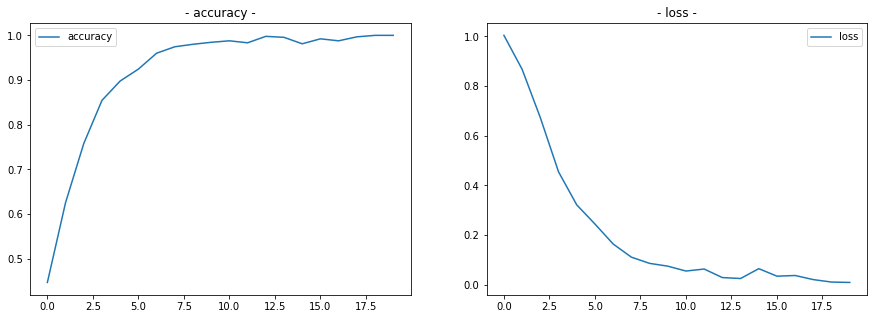

In [ ]:
plt.figure(figsize=(15, 5))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history2.history["accuracy"], label="accuracy")
plt.title("- accuracy -")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history2.history["loss"], label="loss")
plt.title("- loss -")
plt.legend()

plt.show()

* 2번째로 만든 모델의 경우

1. loss값은 2.22
2. 정확도는 0.10 

로 더 저조해진 모습을 보여줬다. 여기서 쓰인 train과 test 데이터의 비율은 [ 900 : 300 ]장을 기본으로 [ 3:1 ]을 만들했고, 하이퍼 파라미터의 경우 epoch을 50으로 만든 것과 dence만 100으로 건드린게 전부라서 뭐가 문젠지 여러모로 심정이 복잡했던 모델이었다. 그래프상으로 보면 오히려 앞서 봤던 1번 모델보다는 좀더 정상적인 그래프 범주가 된 걸 확인할 수 있는데, 원인이 정확치 않아서 답답했다. 어쨌거나 성능이 더 안좋아진 상태라 바로 다음 모델 제작으로 넘어갔다.

<br>

### 2. 데이터 수 10:1 로 변경(6000:600) + 모델 하이퍼 파라미터 변경
-----
#### 2-1. 갯수가 증가된 데이터로 모델 재생성

In [ ]:
# 파일 경로 확인(train 데이터에 가위 100개 파일이 있는 걸 확인) 이번에는 한 라벨링당 2000개씩 총 6000개의 데이터가 사용
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train'

paper  rock  scissor


In [ ]:
img_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train'

In [ ]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들인다
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train/scissor'
resize_images(image_dir_path)

print("- 가위 이미지 resize 완료")

2000  images to be resized.
2000  images resized.
- 가위 이미지 resize 완료


In [ ]:
# 바위 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train/rock'
resize_images(image_dir_path)

print("- 바위 이미지 resize 완료")

2000  images to be resized.
2000  images resized.
- 바위 이미지 resize 완료


In [ ]:
# 보 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train/paper'
resize_images(image_dir_path)

print("- 보 이미지 resize 완료")

2000  images to be resized.
2000  images resized.
- 보 이미지 resize 완료


In [ ]:
# 가위바위보 라벨링

img_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train'

def load_data(img_path, number_of_data=6000):  # 1차 가위바위보 이미지 개수 총합 300
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'): # 가위는 0으로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'): # 바위는 1로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'): # 보는 2로 라벨링
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   
        idx=idx+1
        
    print("- 데이터의 이미지 개수는[", idx,"]개 입니다.")
    return imgs, labels

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/train/'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("- x_train shape : {}".format(x_train.shape))
print("- y_train shape : {}".format(y_train.shape))

- 데이터의 이미지 개수는[ 6000 ]개 입니다.
- x_train shape : (6000, 28, 28, 3)
- y_train shape : (6000,)


라벨:  0


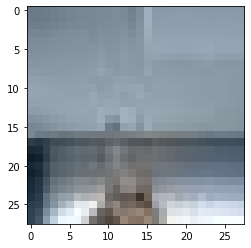

In [ ]:
# 라벨링이 제대로 됐는지 확인하기
plt.imshow(x_train[1])
print('라벨: ', y_train[2])

* 조금 흐릿해서 처음에는 라벨링을 잘못한건가 싶었는데, 희미하게 보이는 손가락 두개를 보니 이번에도 제대로 가위 = 0으로 라벨링이 된 걸 확인할 수 있었다.

#### 2-2. 모델 하이퍼 파라미터 변경

In [ ]:
# Sequential Model을 사용해보자

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,3))) # Conv2D 64로 변경
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu')) # 128로 변경
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu')) # 64로 변경
model.add(keras.layers.Dense(3, activation='softmax'))

* 하이퍼 파라미터 변경 : 이번에는 Conv2D를 각각 64와 128로 변경하고, Dense를 64로 수정했다.

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 3200)              0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [ ]:
# epoch 18, 옵티마이저 adam, 손실함수는 cross entropy로 학습하기
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
history3 = model.fit(x_train_norm, y_train , epochs=18) #초깃값은 25였는데, loss값이 다시 확 올라가서 18로 재조절

Epoch 1/18
188/188 [==============================] - 1s 4ms/step - loss: 0.9739 - accuracy: 0.5060
Epoch 2/18
188/188 [==============================] - 1s 4ms/step - loss: 0.5761 - accuracy: 0.7875
Epoch 3/18
188/188 [==============================] - 1s 3ms/step - loss: 0.3485 - accuracy: 0.8822
Epoch 4/18
188/188 [==============================] - 1s 3ms/step - loss: 0.2394 - accuracy: 0.9252
Epoch 5/18
188/188 [==============================] - 1s 4ms/step - loss: 0.1436 - accuracy: 0.9580
Epoch 6/18
188/188 [==============================] - 1s 3ms/step - loss: 0.1017 - accuracy: 0.9717
Epoch 7/18
188/188 [==============================] - 1s 3ms/step - loss: 0.0715 - accuracy: 0.9793
Epoch 8/18
188/188 [==============================] - 1s 3ms/step - loss: 0.0495 - accuracy: 0.9862
Epoch 9/18
188/188 [==============================] - 1s 3ms/step - loss: 0.0298 - accuracy: 0.9930
Epoch 10/18
188/188 [==============================] - 1s 3ms/step - loss: 0.0330 - accuracy: 0.9907

* 여기서도 에폭 초기값을 25로 잡았는데, 앞서 모델의 하이퍼 파라미터가 바뀌어서 그런지. 채 20이 되지 않았는데도 손실값이 다시 출렁거리는 걸 확인할 수 있었다. accuracy는 1보다는 0.98 대가 가장 이상적인 수치를 보여줬다.(이것도 오버피팅과 과적합의 아슬아슬함을 넘나든 것 같다.)

#### 2-2. 테스트 데이터를 불러온 뒤 모델 확인

In [ ]:
# 테스트 사이즈 내의 이미지들이 제대로 들어있는지 체크
!ls '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/test'

paper  rock  scissor


In [ ]:
# 기본 테스트 이미지 경로
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/test/'

In [ ]:
# 테스트 데이터 로드 + 테스트 이미지 리사이즈
image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/test/rock'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/test/scissor'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/test/paper'
resize_images(image_dir_path)

image_dir_path = '/content/gdrive/MyDrive/aiffel/ex_05/ex05_ver_03/test'
(x_test, y_test)=load_data(image_dir_path)

# 여기서도 입력은 0~1 사이의 값으로 정규화
x_test_norm = x_test/255.0   

200  images to be resized.
200  images resized.
200  images to be resized.
200  images resized.
200  images to be resized.
200  images resized.
- 데이터의 이미지 개수는[ 600 ]개 입니다.


In [ ]:
# 테스트 데이터로 성능을 확인
loss_3, accu_3 = model.evaluate(x_test_norm, y_test, verbose=2)

print("- test_loss: {} ".format(loss_3))
print("- test_accuracy: {}".format(accu_3))

188/188 - 1s - loss: 0.5188 - accuracy: 0.9465 - 543ms/epoch - 3ms/step
188/188 [==============================] - 1s 3ms/step - loss: 0.5188 - accuracy: 0.9465
- test_loss: 0.5188136100769043 
- test_accuracy: 0.9465000033378601


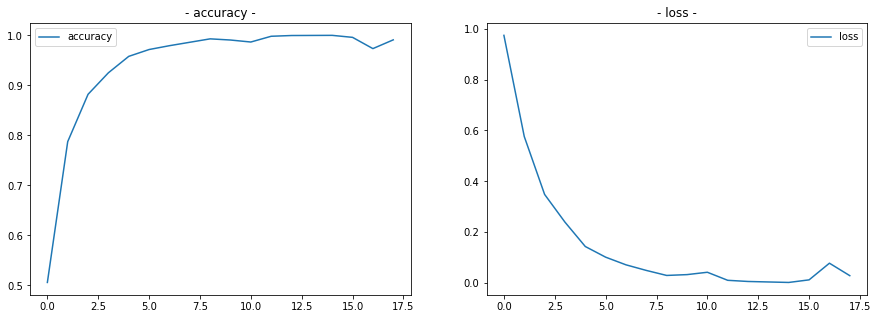

In [ ]:
plt.figure(figsize=(15, 5))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history3.history["accuracy"], label="accuracy")
plt.title("- accuracy -")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history3.history["loss"], label="loss")
plt.title("- loss -")
plt.legend()

plt.show()

* 3번째로 모델의 경우, 

1. loss값은 0.51
2. 정확도는 0.94

여태까지 만든 모델중에서 가장 정밀한 정확도를 보여줬다. 여기서 쓰인 train과 test 데이터의 비율은 [ 6000 : 600 ]장으로 [ 10:1 ]로 만들었고, 하이퍼 파라미터의 경우 처음 모델을 만들때 [ Conv2D ]에서 '128'과 '64', [ Dense ]값 64, 마지막에 [ Epoch ] 초기값을 ' 25 > 20 > 18 '로 낮추면서 적정 숫자를 맞췄다. 마지막에 그래프를 보면 과적화가 된 부분이 있는지 거의 막바지쯤 끝까지 올라갔다가 살짝 떨어졌다 다시 올라가는 걸 보여줬는데, 그 그래프를 뒤집으면 손실값에서도 똑같은 양상을 보여줘서 에폭이 더 줄었어야 하지 않나 고민이 들엇다.(하지만 여러번 돌려본 결과 17보다는 18이 괜찮았으므로 이대로 에폭값은 고정했다) 

- Label: 0,- Predict: 1


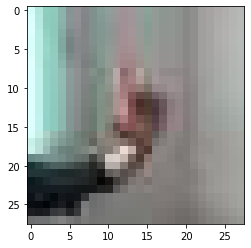

- Label: 0,- Predict: 1


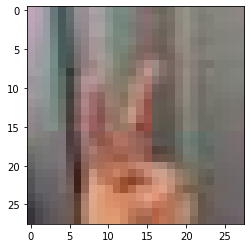

- Label: 0,- Predict: 1


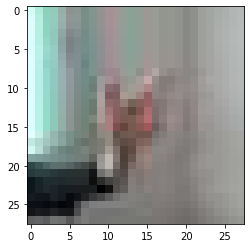

- Label: 2,- Predict: 1


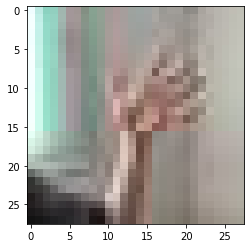

- Label: 0,- Predict: 1


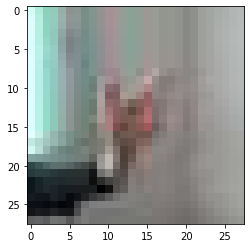

- Label: 2,- Predict: 1


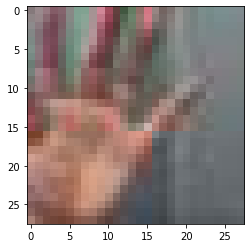

- Label: 2,- Predict: 1


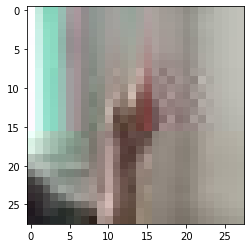

- Label: 0,- Predict: 1


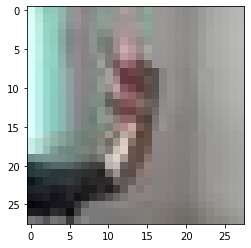

- Label: 0,- Predict: 1


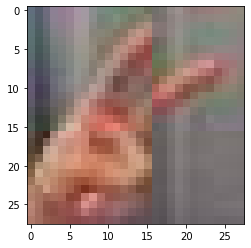

- Label: 0,- Predict: 1


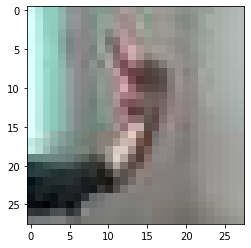

In [ ]:
# 뭐가 틀렸는지 궁금해서 틀린 이미지만 도출해 봄
import random # 랜덤으로 추출하기 위해 random 모듈을 import

# model이 추론한 확률값
pred_result = model.predict(x_test) 
pred_labels = np.argmax(pred_result, axis=1)

w_pred_list=[] 
for i, _ in enumerate(pred_labels): 
    
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if pred_labels[i] != y_test[i]: 
        w_pred_list.append(i) 
        
# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다. 
samples = random.choices(population=w_pred_list, k=10) 

for n in samples: 
    print("- Label: " + str(y_test[n]) + ",- Predict: " + str(pred_labels[n])) 
    plt.imshow(x_test[n], cmap=plt.cm.binary) 
    plt.show()

* 100 가까이 나오는 정확도 중에서도 뭐가 틀린지 궁금해서 600 장의 이미지 중 랜덤으로 나온 틀린 결과들을 추출했는데, 나같아도 이건 못맞추겠다는 생각이 드는게 몇 개 있어서 자연스레 예측값에 납득이 갔다....모델 자체는 틀리지 않은 걸로..

<br>

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

일단 이번 프로젝트의 경우 노드에서의 예시가 Mnist였고, 실제 프로젝트 상의 코드들은 Mnist에서 데이터를 다룬 과정을 응용해서 가위바위보를 구별하는 모델을 만드는 단순한 과정이었음에도 불구하고 Colab으로 들고와서 그런지 꽤 많이 헤멨다.

![20220512175133](https://user-images.githubusercontent.com/100528803/168032057-178d600b-59fd-4570-b4d1-0eedcd1487d9.png)

특히..데이터에서 많이 고통받았는데, 실제로 데이터를 모으는 과정은 아지트에서 앞서 올려주신 데이터들 덕분에 그렇게 힘들진 않았지만, 이 데이터들 중에서(1만개였다) 혹시 모를 중복이 있는지를 체크한 뒤에 이름을 통일시키고, 각각의 갯수에 맞춰서 Train과 Test로 나누는 전처리 과정이 굉장히 오래걸렸다.(원 데이터는 train만 9천개였습니다.....)구글 드라이브에서 3버전의 데이터를 업로드하기까지의 시간도 2시간 넘게 걸려서 올리는 도중에 당황했던 기억도 난다.

![20220512175403](https://user-images.githubusercontent.com/100528803/168039386-038beba2-9941-4c77-a0f4-6adcac3e73a5.png)


심지어 마지막 데이터는 올리는 도중에 프로젝트를 먼저 진행했는데, 이 프로젝트가 다 끝난 뒤에도 한창 업로드 중이었다.....10500개의 데이터에서는 어떤 효율이 나올지 매우 궁금하지만, 지금 마지막 모델의 효율도 충분히 괜찮아서 미련없이 놓아주기로 했다. 

다만, 사이즈가 큰 데이터의 경우 프로젝트 전에 미리미리 올려두는 걸 추천하고 싶다.........

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

![20220512172346](https://user-images.githubusercontent.com/100528803/168031862-4757feb5-3733-4fcf-a952-1f3b87e7c167.png)

제일 궁금했던 건 Epoch에서 손실값이 0에 가까워지는 순간 갑자기 로스값이 확 늘면서 accuracy가 1로 고정되는 점이었다. 마지막 모델의 경우 Conv2와 Dense값을 조절하면서 이 지점이 확 줄었는데, 앞서 두 모델보다 훨씬 적은 구간에서 loss값이 최저치를 찍는 걸 확인할 수 있었다. 이 상관관계를 섬세하게 잡아내기 위해 하이퍼 파라미터를 조절하는 거라고 추측했는데, 좀 더 어떤 관계가 있는지 상세하게 확인할 필요가 있다고 느꼈다.

<br>



In [ ]:
# 정규화 적용 확인 코드
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0



그리고 정규화의 경우, 모델을 훈련시킬 당시 값이 너무 커지거나 하는 것을 막으려고 0~1 사이의 값으로 정규화 시켜주는 것이 좋다는 글을 보고 통일시켰는데, 특성에 관계 없이 최종 손실함수에 대한 미분값의 사이즈가 유사해진다는 설명을 찾아서 봤는데도 와닿는게 없어서 아무래도 더 공부해봐야할 문제 같다....

<br>

#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | 이미지 분류기 모델이 성공적으로 만들어졌는가?<br>                                 | 트레이닝이 정상적으로 수행되었음<br>                                                        |
| **2** | 오버피팅을 극복하기 위한 적절한 시도가 있었는가?<br> | 데이터셋의 다양성, 정규화 등의 시도가 적절하였음                             |
| **3** | 분류모델의 test accuracy가 기준 이상 높게 나왔는가?                                    | 60% 이상 도달하였음 |

In [ ]:
# 변화한 모델들의 수치
model_list = {'Model': ['1번 모델', '2번 모델', '3번 모델'],
              '데이터 수(train:test)':['(300 : 300)', '(900 : 300)', '(6000 : 600)'],
              '변경한 하이퍼 파라미터':['LMS 노드상의 기본값', '[Dense:50], [Epoch:20]','[Conv2:128, 64], [Dense:64], [Epoch:18]'],
              'Loss' : [loss_1, loss_2, loss_3],
              'Accuracy': [accu_1, accu_2, accu_3]}

df = pd.DataFrame(model_list)
df

,Model,데이터 수(train:test),변경한 하이퍼 파라미터,Loss,Accuracy
0,1번 모델,(300 : 300),LMS 노드상의 기본값,1.256491,0.283333
1,2번 모델,(900 : 300),"[Dense:50], [Epoch:20]",2.222622,0.104444
2,3번 모델,(6000 : 600),"[Conv2:128, 64], [Dense:64], [Epoch:18]",0.518814,0.946500


In [ ]:
print(f'- 최종(3번 모델)의 경우 Accuracy [{accu_3*100: .2f}% ]를 달성했습니다.')

- 최종(3번 모델)의 경우 Accuracy [ 94.65% ]를 달성했습니다.


3개의 모델 중에서 가장 최저치를 기록한 건 아이러니하게도 2번 모델이었다. 적어도 데이터 수가 1:1이었던 1번 모델 보다는 수치가 좋지 않을까 예측했었는데, 파라미터값에서 어떤 오류가 있었는지 로스값은 제일 높았고, 정확도는 제일 떨어지는 안습한 결과를 도출했다. 이후에 최종적인 3번 모델에서는 train 데이터 수를 확 늘려서 일단 최대한 많이 학습하게 만들었고, 각각의 하이퍼 파라미터가 어떤 의미를 가지는지 간단하게 검색했던 기억이 난다.

1. 변경했던 [ Conv2 ]의 첫번째 요소들은 '이미지 특징의 수'로 더 많이 늘릴 수록 여러 종류의 feature값을 가져오겠다는 의미다.
2. [ Dense ]레이어의 수는 '분류할때 쓰이는 뉴런의 숫자'를 의미하며, 값이 많으면 많을 수록 더 구조가 복잡해진다는 뜻이다.  특히 Dense 레이어의 경우 분류해야하는 클래스 수로 지정하면 된다고 해서 64로 맞췄던 기억이 난다.
3. [ Epoch ]은 '전체 데이터에 대한 한번의 학습'으로, accuracy와 loss가 교차하는 지점을 과적합으로 생각해서 바로 그 직전에 멈추게 세팅했다.

그 결과, [ Loss ]값은 '0.36'으로 비교적 처음보다 낮은 수치와 더불어 '정확도 94 퍼센트'를 달성함으로서 나름 이번 프로젝트에서 유종의 미를 거둘 수 있었다.

<br>

#### ▶️ 자기 다짐

바로 직전까지는 머신러닝에 대한 프로젝트였으나, 이번서부터는 드디어 딥러닝에 대한 프로젝트가 나왔기 때문에 긴장을 좀 한 상태였다. 그래도 앞서 밑시딥이나 딥러닝 이론들을 LMS 상에서 접해서 그런지 기본적인 개념은 어느정도 알고 있었던 상태에서 코드를 봐서 막 엄청 까다롭거나 하진 않았다. 하지만 아직 텐서플로우나 케라스에 대한 이해가 부족해서 더 능숙하게 파라미터들을 숙지하고 다루고 싶다는 계기가 된 지점이었다.

<br>

## ✔️Reference(참고자료)
---
* https://velog.io/@tmddn0311/mnist-classification
* https://books.google.co.kr/books?id=EVYrEAAAQBAJ&pg=PT267&lpg=PT267&dq=x_train_norm,+x_test_norm+%3D+x_train+%EC%A0%95%EA%B7%9C%ED%99%94&source=bl&ots=7_DmnqGxml&sig=ACfU3U3504AJmKonVssqn8MYpL_7iPi_xA&hl=ko&sa=X&ved=2ahUKEwijsPXLz9n3AhVcgFYBHVVTCAUQ6AF6BAgSEAM#v=onepage&q=x_train_norm%2C%20x_test_norm%20%3D%20x_train%20%EC%A0%95%EA%B7%9C%ED%99%94&f=false
* https://vg-rlo.tistory.com/31
* https://wiserloner.tistory.com/1001
* https://velog.io/@yookyungkho/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%98-%EA%B3%A0%EC%A7%88%EB%B3%91-Overfitting%EA%B3%BC%EC%A0%81%ED%95%A9-%ED%95%B4%EA%B2%B0-%ED%8C%81